In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import geopandas as gpd
# from pysal.contrib.viz import mapping as maps
from shapely.geometry import Point, Polygon, shape
# import re
# from IPython.display import IFrame
import mplleaflet
from geopandas import GeoDataFrame
import geopandas as gpd
from shapely import wkt
from shapely.geometry.multipolygon import MultiPolygon
from progressbar import ProgressBar
from progressbar import *
import time
from collections import Counter
import glob

Eerst moet ik de data importeren. GRONDGEBRUIK_2017 en GEBIEDEN22 zijn bestanden van maps.Amsterdam die het grondgebruik van Amsterdam in 2017 en de verschillende gebieden in Amsterdam in kaart brengen.

In [2]:
df_grond = pd.read_csv("C:/Users/TSmeitink/Downloads/GRONDGEBRUIK_2017.csv", sep=";")
df_district = pd.read_csv("C:/Users/TSmeitink/Downloads/GEBIEDEN22.csv", sep=";")

Hieronder maak ik MultiPolygonen van de WKT_LNG_LAT variabele en die zet ik in de kolom "geometry". Dit helpt verder met geopandas.

In [3]:
df_grond["geometry"] = ''
df_district["geometry"] = ''

for index, value in enumerate(df_grond.WKT_LNG_LAT):
    df_grond.loc[index, "geometry"] = MultiPolygon([wkt.loads(value)])

for index, value in enumerate(df_district.WKT_LNG_LAT):
    df_district.loc[index, "geometry"] = MultiPolygon([wkt.loads(value)])

Hier maak ik Geo DataFrames van mijn pandas DataFrames

In [4]:
gdf_g = GeoDataFrame(df_grond)
gdf_d = GeoDataFrame(df_district)

Om te bepalen welke gebieden beschikbaar zijn voor het planten van bomen, moeten we ook weten wat voor soorten gebieden er zijn in Amsterdam. Dit doen we met de unique() functie.

Hieronder maken we een selectie van gebieden die we beschikbaar achten voor het planten van boomclusters.

In [5]:
gr_areas = ["Bouwterrein woonbestemming", "Bouwterrein niet-woon bestemming", "Tijdelijke opslag van grond",
           "Semi verhard overig terrein", "Park en plantsoen", "Open droog-natuurlijk terrein", "Open nat-natuurlijk terrein",
           "Open nat-natuurlijk terrein met schotse hooglanders", "Open nat-natuurlijk terrein waterpartijen", ""]
gr_areas1 = ["Woonterrein"]

In de stappen hieronder maak ik een unie van district polygonen (van de 22 gebieden data) en selecteer alleen de polygonen (van de grondgebruik data) die binnen deze unie vallen. De rest hoeven we niet te visualiseren.

In [6]:
Amsterdam = gdf_d.geometry.unary_union

In [7]:
df_grond["InDistrict"] = ''
for index, value in enumerate(df_grond.geometry):
    if Amsterdam.contains(value):
        df_grond.loc[index, "InDistrict"] = True
    else:
        df_grond.loc[index, "InDistrict"] = False

In [18]:
df_temp = df_grond[df_grond.AMScode_Oms.isin(df_grond.columns.values)]
df_gg = df_temp[df_grond.InDistrict.isin([True])]

C:\Users\TSmeitink\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Hier maken we een GeoDataFrame van al het grond dat voldoet aan onze condities. Deze condities zijn of ze het soort gebieden zijn die wij bruikbaar achten voor boomplanting EN of het grond binnen de 22 districten van Amsterdam valt.

In [19]:
gdf_gg = GeoDataFrame(df_gg).reset_index()

Nu importeren we de 'boomdata' van maps.Amsterdam

In [20]:
df_b = pd.concat([pd.read_csv(file, dtype=str, sep=';') for file in glob.glob('C:/Users/TSmeitink/Downloads/BOMEN*')], 
                    axis=0, ignore_index=True)

In [ ]:
df_b["geometry"] = ''
df_b["LAT2"] = df_b.LAT.str.replace(',', '.').astype(float)
df_b["LNG2"] = df_b.LNG.str.replace(',', '.').astype(float)

In [ ]:
df_b.geometry = df_b.apply(lambda x : Point([x['LNG2'],x['LAT2']]),axis=1) 
gdf_b = GeoDataFrame(df_b, geometry="geometry")

In [ ]:
gdf_aantal_bomen = gpd.sjoin(gdf_gg, gdf_b, how='left', op='contains').groupby('OBJECTNUMMER_left').count().\
    Boomtype.reset_index().\
    rename(columns={'index': 'terrein'}).\
    rename(columns={'Boomtype': 'aantal_bomen'})

In [ ]:
gdf_gg["aantal_bomen"] = gdf_aantal_bomen.aantal_bomen
gdf_gg["aantal_bomen_m2"] = gdf_gg.aantal_bomen / gdf_gg.Oppervlakte_m2
gdf_gg["aantal_bomen_index"] = gdf_gg.aantal_bomen_m2 / gdf_gg.aantal_bomen_m2.max()

In [ ]:
def colorBins (row):
    if row['aantal_bomen_index'] <= gdf_gg.aantal_bomen_index.quantile(0.1):
        return 1
    elif row['aantal_bomen_index'] <= gdf_gg.aantal_bomen_index.quantile(0.2):
        return 2
    elif row['aantal_bomen_index'] <= gdf_gg.aantal_bomen_index.quantile(0.3):
        return 3
    elif row['aantal_bomen_index'] <= gdf_gg.aantal_bomen_index.quantile(0.4):
        return 4
    elif row['aantal_bomen_index'] <= gdf_gg.aantal_bomen_index.quantile(0.5):
        return 5
    elif row['aantal_bomen_index'] <= gdf_gg.aantal_bomen_index.quantile(0.6):
        return 6
    elif row['aantal_bomen_index'] <= gdf_gg.aantal_bomen_index.quantile(0.7):
        return 7
    elif row['aantal_bomen_index'] <= gdf_gg.aantal_bomen_index.quantile(0.8):
        return 8
    elif row['aantal_bomen_index'] <= gdf_gg.aantal_bomen_index.quantile(0.9):
        return 9
    else:
        return 10

In [ ]:
gdf_gg["colorbins"] = gdf_gg.apply(lambda row: colorBins(row), axis=1)

Hieronder plotten we de data op een interactieve map met behulp van de package 'mpleaflet'. Een nieuwe map wordt geopend in de browser met als extensie '.html'.

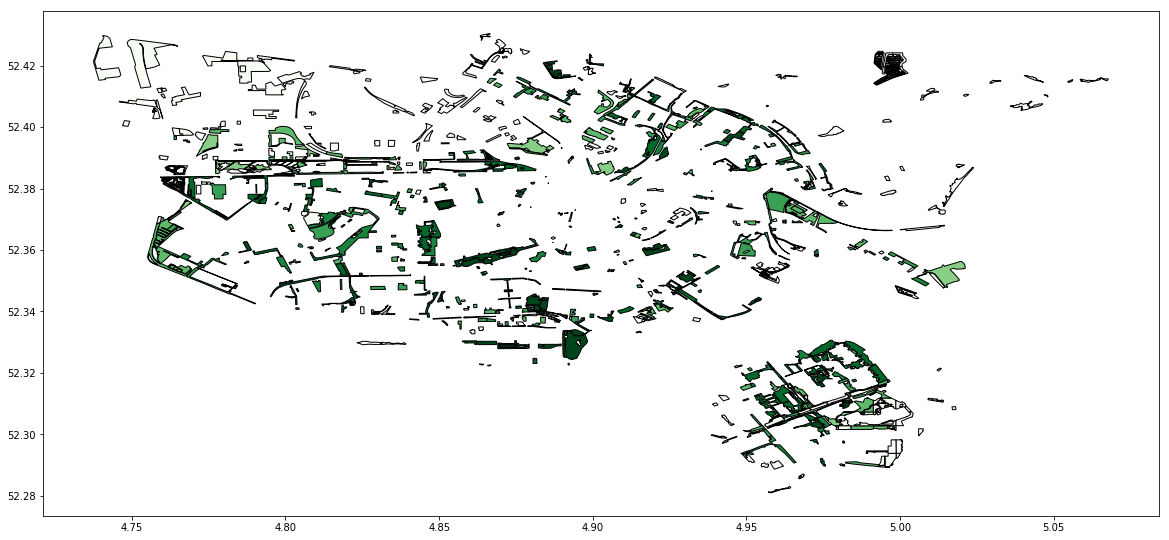

In [17]:
fig, ax = plt.subplots(figsize=(20,20))
# gdf_d.plot(ax=ax)
gdf_gg.plot(ax=ax, column='colorbins', cmap='Greens', alpha=1, linewidth=1, edgecolor='black')
# mplleaflet.show(fig=ax.figure)